In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%pip install keras

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

dataset_path = '../dataset'  # Update to your dataset path
model_path = '../model'      # Update to your model save path
save_model = 0

# === Load and Normalize Individual Feature ===
def read_and_norm(dataset_path, type_, feature):
    with open(f'{dataset_path}/{type_}/{feature}.txt', 'rb') as f:
        matrix = [[float(x) for x in line.split()] for line in f]
    matrix = np.array(matrix)
    min_m, max_m = matrix.min(), matrix.max()
    matrix = (matrix - min_m) / (max_m - min_m)
    return matrix

# === Load All Features and Labels ===
def load_full_dataset(type_):
    classification = np.loadtxt(f'{dataset_path}/{type_}/classification.txt')
    classification = np.array(classification).reshape(-1, 1)

    with open(f'{dataset_path}/{type_}/hr.txt', "r") as file:
        hr, bad_rows = [], []
        for idx, line in enumerate(file):
            cols = line.split()
            if len(cols) == 9:
                bad_rows.append(idx)
            else:
                hr.append([float(val) for val in cols])
    hr = np.array(hr)

    shape = read_and_norm(dataset_path, type_, 'shape')
    el = read_and_norm(dataset_path, type_, 'el')
    dist = read_and_norm(dataset_path, type_, 'dist')

    # Remove bad rows consistently across all features
    classification = np.delete(classification, bad_rows, 0)
    shape = np.delete(shape, bad_rows, 0)
    el = np.delete(el, bad_rows, 0)
    dist = np.delete(dist, bad_rows, 0)

    # Combine features into input
    data_X = np.array([p for p in zip(shape, dist, el, hr)])
    data_X = data_X.reshape(data_X.shape[0], data_X.shape[1], data_X.shape[2], 1)

    return data_X, classification

# === Define and Train the CNN Model ===
def evaluate_model_2dconv(trainX, trainy, testX, testy):
    model = Sequential()
    model.add(Conv2D(filters=9, kernel_size=(4,1), activation='relu', input_shape=trainX.shape[1:]))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=3, kernel_size=(1,3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)

    history = model.fit(trainX, trainy, epochs=300, batch_size=1, validation_split=0.2, callbacks=[es], verbose=1)
    _, accuracy = model.evaluate(testX, testy, verbose=1)

    pred_probs = model.predict(testX)
    pred_labels = (pred_probs >= 0.478).astype(int)

    results = pd.DataFrame({
        'Prob': pred_probs.reshape(-1),
        'Pred': pred_labels.reshape(-1),
        'True': testy.reshape(-1)
    })

    if save_model:
        model.save(f'{model_path}/my_model.keras')

    # === Residue Pair Analysis ===
    residue_pairs = []
    with open(f'{dataset_path}/test/dataset.txt', 'r') as f:
        lines = f.readlines()
        #for i in range(2,11)
        for line in lines[1:]:
            tokens = line.strip().split(",")
            if len(tokens) >= 2:
                residue_pairs.append((tokens[1], tokens[2]))
                """residue_pairs.append((tokens[1], tokens[3]))
                residue_pairs.append((tokens[1], tokens[4]))
                residue_pairs.append((tokens[1], tokens[5]))
                residue_pairs.append((tokens[1], tokens[6]))
                residue_pairs.append((tokens[1], tokens[7]))
                residue_pairs.append((tokens[1], tokens[8]))"""


    if len(residue_pairs) == len(results):
        results['ResidueA'] = [a for a, b in residue_pairs]
        results['ResidueB'] = [b for a, b in residue_pairs]

        grouped = results.groupby(['ResidueA', 'ResidueB'])
        pair_accuracy = grouped.apply(lambda df: (df['Pred'] == df['True']).mean()).reset_index()
        pair_accuracy.columns = ['ResidueA', 'ResidueB', 'Accuracy']
        pair_accuracy.to_csv('pairwise_accuracy.csv', index=False)
        print("\nTop 10 residue pairs by prediction accuracy:")
        print(pair_accuracy.sort_values(by='Accuracy', ascending=False).head(10))

        pair_accuracy.to_csv('pairwise_accuracy.csv', index=False)

       

    else:
        print(f"Residue pair count mismatch: {len(residue_pairs)} vs predictions: {len(results)}")

    return accuracy, history

# === Report Summary ===
def summarize_results(scores):
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# === Run Training and Evaluation ===
def run_experiment(repeats=1):
    trainX, trainy = load_full_dataset('train')
    testX, testy = load_full_dataset('test')
    print(f"Train shape: {trainX.shape}, Test shape: {testX.shape}")
    scores = []
    for r in range(repeats):
        print(f"\n>>> Run #{r+1}")
        score, _ = evaluate_model_2dconv(trainX, trainy, testX, testy)
        scores.append(score * 100.0)

    summarize_results(scores)

run_experiment()



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Train shape: (2990, 4, 10, 1), Test shape: (1282, 4, 10, 1)

>>> Run #1
Epoch 1/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.6035 - loss: 0.6506 - val_accuracy: 0.7492 - val_loss: 0.5405
Epoch 2/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.7274 - loss: 0.5539 - val_accuracy: 0.7692 - val_loss: 0.4908
Epoch 3/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - accuracy: 0.7436 - loss: 0.5448 - val_accuracy: 0.7876 - val_loss: 0.4660
Epoch 4/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.7808 - loss: 0.4931 - val_accuracy: 0.7475 - val_loss: 0.4883
Epoch 5/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - accuracy: 0.7669 - loss: 0.5163 - val_accuracy: 0.7893 - val_loss: 0.5133
Epoch 6/300
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.7722 - loss: 0.

/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_58241/201853374.py:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pair_accuracy = grouped.apply(lambda df: (df['Pred'] == df['True']).mean()).reset_index()


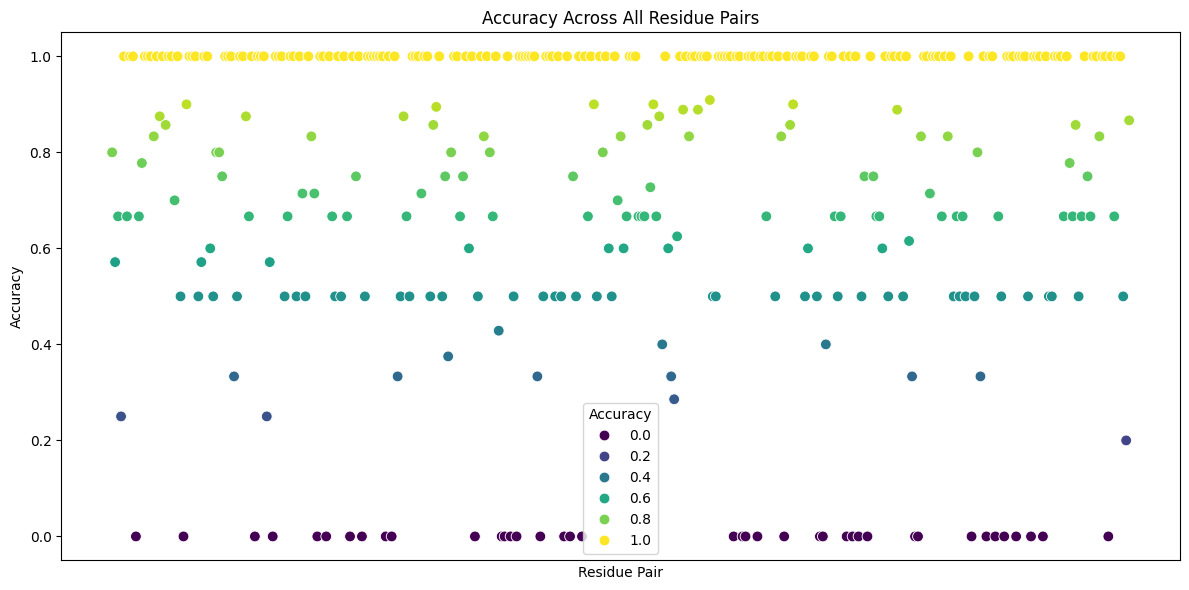

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pair_accuracy = pd.read_csv('pairwise_accuracy.csv')

# Add a new column for combined residue pair names
pair_accuracy['ResiduePair'] = pair_accuracy.apply(lambda row: f"{row['ResidueA']}-{row['ResidueB']}", axis=1)

# Scatter plot for all residue pairs (no x-axis labels)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=pair_accuracy,
    x='ResiduePair',
    y='Accuracy',
    hue='Accuracy',
    palette='viridis',
    s=60
)

plt.xticks([], [])  # <- removes all x-axis tick labels
plt.title("Accuracy Across All Residue Pairs")
plt.xlabel("Residue Pair")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("residue_pair_accuracy_scatter.png")
plt.show()


In [ ]:
# Re-import necessary libraries after code execution environment reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the uploaded pairwise accuracy file
df_accuracy = pd.read_csv("pairwise_accuracy.csv")

# Combine residue pairs into a single label
df_accuracy['ResiduePair'] = df_accuracy['ResidueA'] + "-" + df_accuracy['ResidueB']

# Sort by accuracy
df_accuracy_sorted = df_accuracy.sort_values(by='Accuracy', ascending=False)

# Create a box plot of accuracy distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accuracy_sorted, y='Accuracy')
plt.title("Distribution of Residue Pairwise Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Load the uploaded pairwise accuracy file
pair_accuracy = pd.read_csv("pairwise_accuracy.csv")

# Optional: Plot
top10 = pair_accuracy.sort_values(by='Accuracy', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    x='Accuracy',
    y=top10.apply(lambda row: f"{row['ResidueA']}-{row['ResidueB']}", axis=1)
)
plt.title("Top 10 Residue Pairs by Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Residue Pair")
plt.tight_layout()
plt.savefig("top10_residue_pairs.png")
plt.show()